In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [335]:
sns.set()

In [336]:
cpi_df = pd.read_csv("./data/CPI_data.csv", parse_dates=["Date"])
cpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1773 entries, 0 to 1772
Data columns (total 4 columns):
Date          1773 non-null datetime64[ns]
CPI           1773 non-null float64
Adjusted      1770 non-null float64
Unnamed: 3    3 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 55.5 KB


In [337]:
cpi_df = cpi_df[["Date", "CPI"]]
cpi_df["Year"] = cpi_df.Date.dt.year
cpi_df = cpi_df[cpi_df.Year.between(1955,2012, inclusive=True)]
cpi_df.reset_index(drop=True, inplace=True)
cpi_df = cpi_df.groupby("Year").mean()
cpi_df["Factor"] =  cpi_df.loc[2012,"CPI"] / cpi_df

cpi_df

,CPI,Factor
Year,,
1955,26.775000,8.574936
1956,27.183333,8.446128
1957,28.091667,8.173026
1958,28.858333,7.955897
1959,29.150000,7.876292
1960,29.575000,7.763108
1961,29.891667,7.680867
1962,30.250000,7.589882
1963,30.625000,7.496944


In [339]:
df = pd.read_csv("./data/processed/merged_data2.csv", header = 0,
                 names=["Company", "DetailURL", "Profits", "Rank", "Revenue", "Self", "Year"],)

In [340]:
df.head()

,Company,DetailURL,Profits,Rank,Revenue,Self,Year
0,General Motors,https://money.cnn.com/magazines/fortune/fortun...,806.0,1.0,9823.5,https://money.cnn.com/magazines/fortune/fortun...,1955
1,Exxon Mobil,https://money.cnn.com/magazines/fortune/fortun...,584.8,2.0,5661.4,https://money.cnn.com/magazines/fortune/fortun...,1955
2,U.S. Steel,https://money.cnn.com/magazines/fortune/fortun...,195.4,3.0,3250.4,https://money.cnn.com/magazines/fortune/fortun...,1955
3,General Electric,https://money.cnn.com/magazines/fortune/fortun...,212.6,4.0,2959.1,https://money.cnn.com/magazines/fortune/fortun...,1955
4,Esmark,https://money.cnn.com/magazines/fortune/fortun...,19.1,5.0,2510.8,https://money.cnn.com/magazines/fortune/fortun...,1955


In [341]:
df.drop(["DetailURL", "Self"], axis=1, inplace=True)


df.head()

,Company,Profits,Rank,Revenue,Year
0,General Motors,806.0,1.0,9823.5,1955
1,Exxon Mobil,584.8,2.0,5661.4,1955
2,U.S. Steel,195.4,3.0,3250.4,1955
3,General Electric,212.6,4.0,2959.1,1955
4,Esmark,19.1,5.0,2510.8,1955


In [342]:
df = df[df["Rank"].notnull()]
df = df.merge(cpi_df.reset_index())
df["AdjRevenue"] = df["Revenue"] * df["Factor"]
df["AdjProfits"] = df["Profits"] * df["Factor"]

df.head()

,Company,Profits,Rank,Revenue,Year,CPI,Factor,AdjRevenue,AdjProfits
0,General Motors,806.0,1.0,9823.5,1955,26.775,8.574936,84235.885728,6911.398575
1,Exxon Mobil,584.8,2.0,5661.4,1955,26.775,8.574936,48546.143784,5014.622688
2,U.S. Steel,195.4,3.0,3250.4,1955,26.775,8.574936,27871.972614,1675.542533
3,General Electric,212.6,4.0,2959.1,1955,26.775,8.574936,25374.093700,1823.031435
4,Esmark,19.1,5.0,2510.8,1955,26.775,8.574936,21529.949803,163.781281


In [343]:
df.tail()

,Company,Profits,Rank,Revenue,Year,CPI,Factor,AdjRevenue,AdjProfits
28995,Rockwell Collins,634.0,496.0,4825.0,2012,229.593917,1.0,4825.0,634.0
28996,Erie Insurance Group,169.0,497.0,4824.0,2012,229.593917,1.0,4824.0,169.0
28997,Nash-Finch,35.8,498.0,4807.2,2012,229.593917,1.0,4807.2,35.8
28998,KeyCorp,920.0,499.0,4780.0,2012,229.593917,1.0,4780.0,920.0
28999,Molina Healthcare,20.8,500.0,4769.9,2012,229.593917,1.0,4769.9,20.8


In [345]:
df.groupby("Year").AdjRevenue.mean()

Year
1955     2345.810996
1956     2726.384826
1957     2849.223046
1958     2996.384792
1959     2785.543665
1960     3064.806691
1961     3144.911031
1962     3175.519913
1963     3434.831450
1964     3628.459326
1965     3883.802193
1966     4216.640175
1967     4578.072644
1968     4737.786092
1969     5073.053774
1970     5259.734365
1971     5261.083694
1972     5522.317701
1973     5767.218200
1974     6212.474735
1975     7108.287387
1976     6981.495852
1977     7357.646773
1978     7648.741483
1979     7710.789658
1980     8053.432080
1981     8333.913490
1982     8438.381563
1983     7709.466356
1984     7455.583623
1985     7507.464089
1986     7570.443836
1987     6965.668276
1988     7297.951091
1989     7494.015818
1990     7608.207914
1991     7765.780367
1992     7408.721073
1993     7519.179447
1994     7342.557663
1995    12859.475267
1996    13731.204881
1997    14524.766361
1998    15545.418949
1999    15817.902075
2000    16866.115248
2001    18622.209662
2002    

In [10]:
df["profitPercent"] = df.Profits/df.Revenue
df.head()

,Company,Profits,Rank,Revenue,Year,CPI,Factor,AdjRevenue,AdjProfits,profitPercent
0,General Motors,806.0,1.0,9823.5,1955,26.775,8.574936,84235.885728,6911.398575,0.082048
1,Exxon Mobil,584.8,2.0,5661.4,1955,26.775,8.574936,48546.143784,5014.622688,0.103296
2,U.S. Steel,195.4,3.0,3250.4,1955,26.775,8.574936,27871.972614,1675.542533,0.060116
3,General Electric,212.6,4.0,2959.1,1955,26.775,8.574936,25374.093700,1823.031435,0.071846
4,Esmark,19.1,5.0,2510.8,1955,26.775,8.574936,21529.949803,163.781281,0.007607


In [11]:
# df.groupby("Year").count()

In [12]:
df2 = df.reset_index(drop=True)

In [13]:
df2.head(3)

,Company,Profits,Rank,Revenue,Year,CPI,Factor,AdjRevenue,AdjProfits,profitPercent
0,General Motors,806.0,1.0,9823.5,1955,26.775,8.574936,84235.885728,6911.398575,0.082048
1,Exxon Mobil,584.8,2.0,5661.4,1955,26.775,8.574936,48546.143784,5014.622688,0.103296
2,U.S. Steel,195.4,3.0,3250.4,1955,26.775,8.574936,27871.972614,1675.542533,0.060116


In [14]:
MIN_YEAR = df2.Year.min()
MAX_YEAR = df2.Year.max()


print(MIN_YEAR)
print(MAX_YEAR)
grouped = df2.groupby("Company")

1955
2012


In [257]:
data_df = pd.DataFrame({"Company" : list(grouped.groups.keys()),
                        'MinRankYear' : grouped.apply(lambda x: x.loc[x["Rank"].idxmin(),"Year"]).values,
                        'MaxRankYear' : grouped.apply(lambda x: x.loc[x["Rank"].idxmax(),"Year"]).values,
                        'MinRank': grouped.apply(lambda x: x["Rank"].min()),
                        'MaxRank': grouped.apply(lambda x: x["Rank"].max()),
                        "FirstYearInList" : grouped.first()["Year"],
                        "LastYearInList" : grouped.last()["Year"],
                        "MinRevenue": grouped.apply(lambda x: x["Revenue"].min()),
                        "MaxRevenue": grouped.apply(lambda x: x["Revenue"].max()),
                        "MinYearRevenue": grouped.apply(lambda x: x.loc[x["Rank"].idxmin(),"AdjRevenue"]).values,
                        "MaxYearRevenue": grouped.apply(lambda x: x.loc[x["Rank"].idxmax(),"AdjRevenue"]).values,
                        "MinProfit": grouped.apply(lambda x: x["Profits"].min()),
                        "MaxProfit": grouped.apply(lambda x: x["Profits"].max()),
                        "MinYearProfit": grouped.apply(lambda x: x.loc[x["Rank"].idxmin(),"AdjProfits"]).values,
                        "MaxYearProfit": grouped.apply(lambda x: x.loc[x["Rank"].idxmax(),"AdjProfits"]).values                        
                      })

data_df["InTheList"] = data_df["LastYearInList"] == MAX_YEAR
data_df["NoOfYearsInList"] = data_df["LastYearInList"] - data_df["FirstYearInList"] +1

data_df["NoOfYearsBucket"] = data_df.NoOfYearsInList.map(lambda x: str((x//5)*5 + 1).zfill(2) 
                                                           + "-" + str((x//5)*5+5).zfill(2))





In [258]:
data_df.head(5)

,Company,MinRankYear,MaxRankYear,MinRank,MaxRank,FirstYearInList,LastYearInList,MinRevenue,MaxRevenue,MinYearRevenue,MaxYearRevenue,MinProfit,MaxProfit,MinYearProfit,MaxYearProfit,InTheList,NoOfYearsInList,NoOfYearsBucket
Company,,,,,,,,,,,,,,,,,,
3Com,3Com,2000,1994,294.0,496.0,1994,2001,617.2,5772.1,7695.929422,956.015283,30.2,674.3,538.519065,59.789679,False,8,06-10
3M,3M,1993,1955,28.0,131.0,1955,2012,230.9,29611.0,22064.856153,1979.952768,24.6,4283.0,1959.660566,210.943430,True,58,56-60
A-T-O,A-T-O,1970,1968,258.0,321.0,1968,1971,242.3,378.9,2240.647393,1599.346603,2.1,10.7,63.275078,60.726326,False,4,01-05
A. Schulman,A. Schulman,1992,1988,414.0,498.0,1988,1994,464.0,740.1,1210.992691,900.837804,20.0,43.8,69.213607,38.829216,False,7,06-10
A.H. Robins,A.H. Robins,1989,1983,346.0,462.0,1983,1989,482.3,934.0,1729.825637,1111.778574,-1632.0,81.8,107.419579,112.261283,False,7,06-10


In [17]:
no_years_df = pd.DataFrame({"Count":data_df["NoOfYearsInList"].value_counts()})
no_years_df.index.name="NoOfYears"
no_years_df = no_years_df.sort_index().reset_index()

In [18]:
no_years_df.head()

,NoOfYears,Count
0,1,223
1,2,174
2,3,139
3,4,129
4,5,128


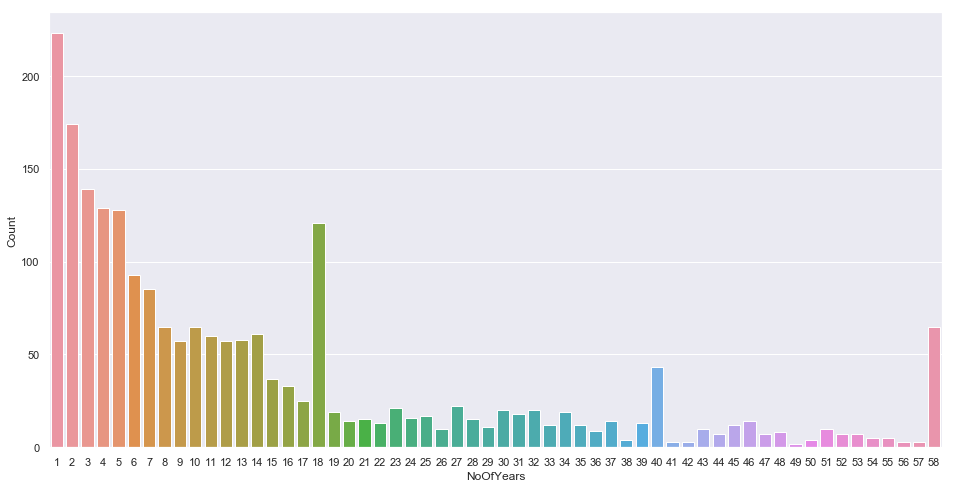

In [19]:
plt.figure(figsize=(16,8))
sns.barplot(no_years_df.NoOfYears, no_years_df.Count)

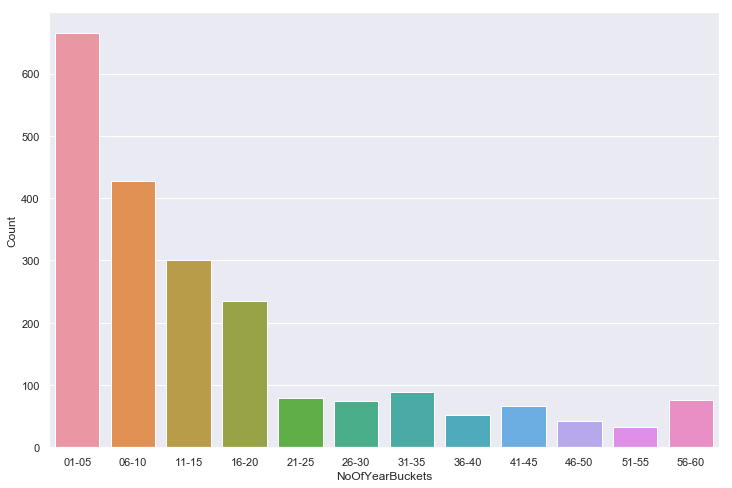

In [20]:
# no_years_df["NoOfYearBuckets"] = str(no_years_df.NoOfYears//5 + 1) + "-" + str(no_years_df.index//5+5)
no_years_df["NoOfYearBuckets"] = no_years_df.NoOfYears.map(lambda x: str((x//5)*5 + 1).zfill(2) 
                                                           + "-" + str((x//5)*5+5).zfill(2))

no_years_df = no_years_df.groupby("NoOfYearBuckets").sum().reset_index()
no_years_df
plt.figure(figsize=(12,8))
sns.barplot(no_years_df.NoOfYearBuckets, no_years_df.Count)

In [21]:
added_companies_by_year = pd.DataFrame({"NoOfCompaniesAdded":data_df["FirstYearInList"].value_counts()})
added_companies_by_year.index.name="Year"
added_companies_by_year = added_companies_by_year.sort_index().reset_index()

In [22]:
added_companies_by_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
Year                  58 non-null int64
NoOfCompaniesAdded    58 non-null int64
dtypes: int64(2)
memory usage: 1008.0 bytes


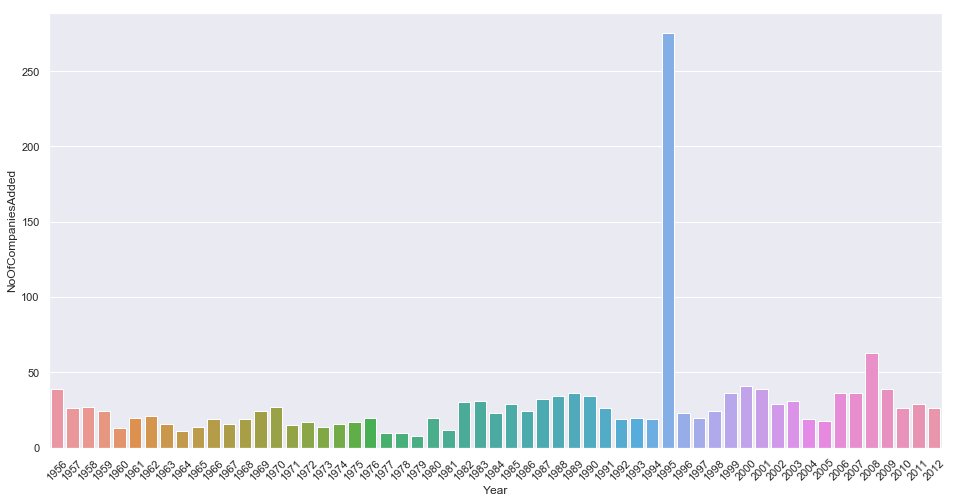

In [23]:
plt.figure(figsize=(16,8))
g = sns.barplot(added_companies_by_year.Year[1:], added_companies_by_year.NoOfCompaniesAdded[1:])
loc, labels = plt.xticks()
_ = g.set_xticklabels(labels, rotation=45)

In [291]:
# YearCompanies_15 = data_df[(data_df["NoOfYearsInList"]>50) & (data_df["InTheList"]==False)].Company

YearCompanies_15 = data_df[(data_df["NoOfYearsInList"] > 50) & (data_df["InTheList"]==True)].Company

In [292]:
YearCompanies_15
sample_year15 = YearCompanies_15.sample(15, replace=False)

In [293]:
df3 = df2[df2.Company.isin(sample_year15)][["Company","Year", "AdjRevenue"]]

In [294]:
# df3

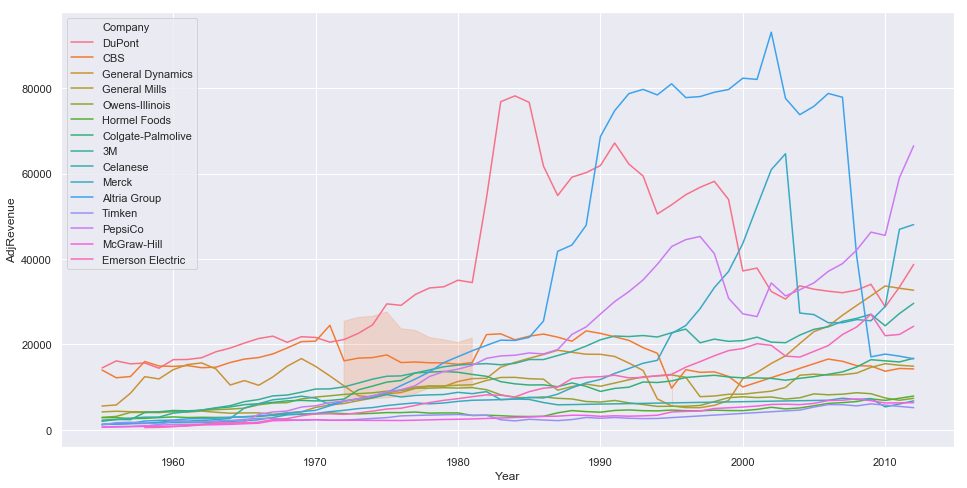

In [295]:
plt.figure(figsize=(16,8))
sns.lineplot(x="Year", y="AdjRevenue", hue="Company", data=df3)

In [296]:
df2.head(5)

,Company,Profits,Rank,Revenue,Year,CPI,Factor,AdjRevenue,AdjProfits,profitPercent
0,General Motors,806.0,1.0,9823.5,1955,26.775,8.574936,84235.885728,6911.398575,0.082048
1,Exxon Mobil,584.8,2.0,5661.4,1955,26.775,8.574936,48546.143784,5014.622688,0.103296
2,U.S. Steel,195.4,3.0,3250.4,1955,26.775,8.574936,27871.972614,1675.542533,0.060116
3,General Electric,212.6,4.0,2959.1,1955,26.775,8.574936,25374.093700,1823.031435,0.071846
4,Esmark,19.1,5.0,2510.8,1955,26.775,8.574936,21529.949803,163.781281,0.007607


In [297]:
df3 = df2.assign(AdjRevenueNorm = df2.AdjRevenue.div(df2.groupby("Company")["AdjRevenue"].transform("max")),
                 AdjProfitNorm = df2.AdjProfits.div(df2.groupby("Company")["AdjProfits"].transform("max")),
                 AdjYear = df2.Year - df2.groupby("Company")["Year"].transform("min"),
                )

In [298]:
# df3.sample(10)

In [299]:
df4 = df3[df2.Company.isin(sample_year15)][["Company","AdjYear", "AdjRevenueNorm", "AdjProfitNorm"]]

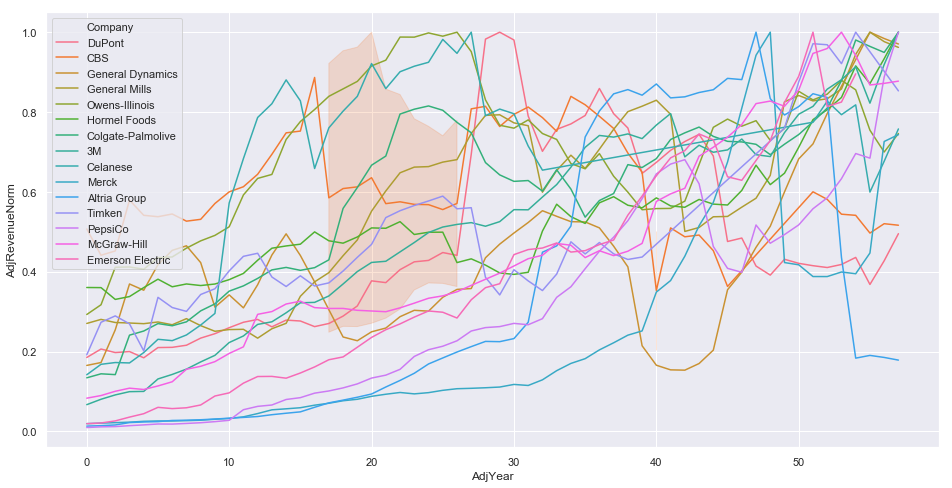

In [300]:
plt.figure(figsize=(16,8))
# g = sns.FacetGrid(df3, col="Company", col_wrap=3)
sns.lineplot(x="AdjYear", y="AdjRevenueNorm", hue="Company" , data=df4)

# g = g.map(plt.plot, x=df3["AdjYear"], y=df3["AdjRevenueNorm"])

# plt.plot(x=df3["AdjYear"], y=df3["AdjRevenueNorm"])




(-1, 1)

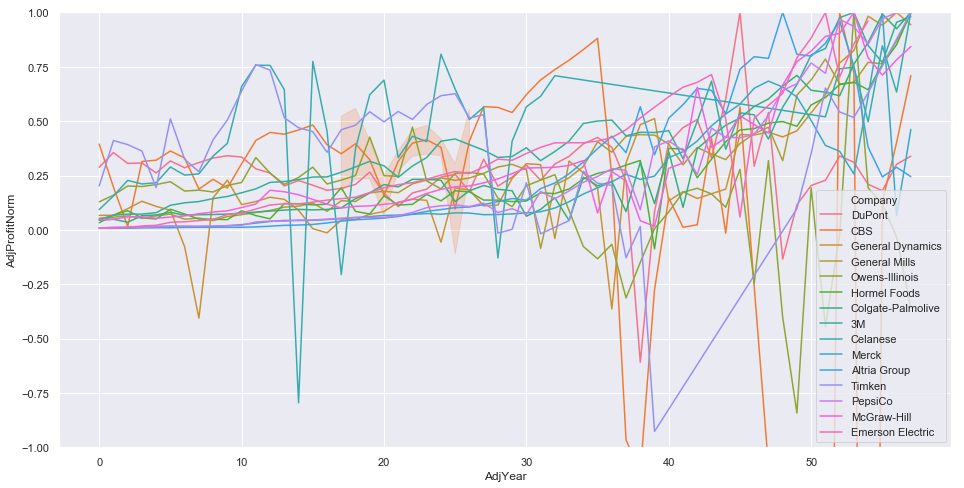

In [324]:
plt.figure(figsize=(16,8))
# g = sns.FacetGrid(df3, col="Company", col_wrap=3)
sns.lineplot(x="AdjYear", y="AdjProfitNorm", hue="Company" , data=df4)
plt.ylim(-1, 1)


# g = g.map(plt.plot, x=df3["AdjYear"], y=df3["AdjRevenueNorm"])

# plt.plot(x=df3["AdjYear"], y=df3["AdjRevenueNorm"])




In [302]:
df5 = pd.merge(df3.reset_index(drop=True), data_df,on="Company", how="left")

In [303]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29000 entries, 0 to 28999
Data columns (total 30 columns):
Company            29000 non-null object
Profits            28626 non-null float64
Rank               29000 non-null float64
Revenue            29000 non-null float64
Year               29000 non-null int64
CPI                29000 non-null float64
Factor             29000 non-null float64
AdjRevenue         29000 non-null float64
AdjProfits         28626 non-null float64
profitPercent      28626 non-null float64
AdjRevenueNorm     29000 non-null float64
AdjProfitNorm      28626 non-null float64
AdjYear            29000 non-null int64
MinRankYear        29000 non-null int64
MaxRankYear        29000 non-null int64
MinRank            29000 non-null float64
MaxRank            29000 non-null float64
FirstYearInList    29000 non-null int64
LastYearInList     29000 non-null int64
MinRevenue         29000 non-null float64
MaxRevenue         29000 non-null float64
MinYearRevenue     290

In [304]:
df6 = df5.groupby(["AdjYear","NoOfYearsBucket", "InTheList"]).mean()

In [305]:
df6 = df6.reset_index()

In [306]:
df6.head()

,AdjYear,NoOfYearsBucket,InTheList,Profits,Rank,Revenue,Year,CPI,Factor,AdjRevenue,...,LastYearInList,MinRevenue,MaxRevenue,MinYearRevenue,MaxYearRevenue,MinProfit,MaxProfit,MinYearProfit,MaxYearProfit,NoOfYearsInList
0,0,01-05,False,0.550617,399.853448,2895.604310,1986.279310,122.287517,3.243313,3945.552219,...,1987.524138,2795.138276,3423.461552,4511.881334,3836.210634,-117.480986,82.730282,33.301117,-23.573420,2.244828
1,0,01-05,True,493.874118,372.200000,9804.200000,2010.623529,222.497276,1.032656,10046.989762,...,2012.000000,9484.290588,11368.374118,11281.014437,9788.838147,413.695294,869.080000,728.276029,558.529230,2.376471
2,0,06-10,False,84.068371,384.656442,2291.127301,1982.659509,105.615084,3.517838,3634.280583,...,1988.423313,2078.200613,4677.107055,6270.436387,3348.754173,-170.478233,327.086435,187.304261,137.961720,6.763804
3,0,06-10,True,993.608738,318.038835,15124.702913,2006.893204,207.642906,1.107687,16621.546260,...,2012.000000,13119.344660,21490.129126,21474.830168,14593.129166,-1250.941748,2067.524272,1560.333014,-287.161518,6.106796
4,0,11-15,False,122.977542,343.555556,2362.141152,1976.761317,86.109499,4.456359,4160.489784,...,1987.674897,2108.125103,6689.600000,8469.994287,3863.959108,-404.739749,615.968201,511.576660,238.876068,11.913580


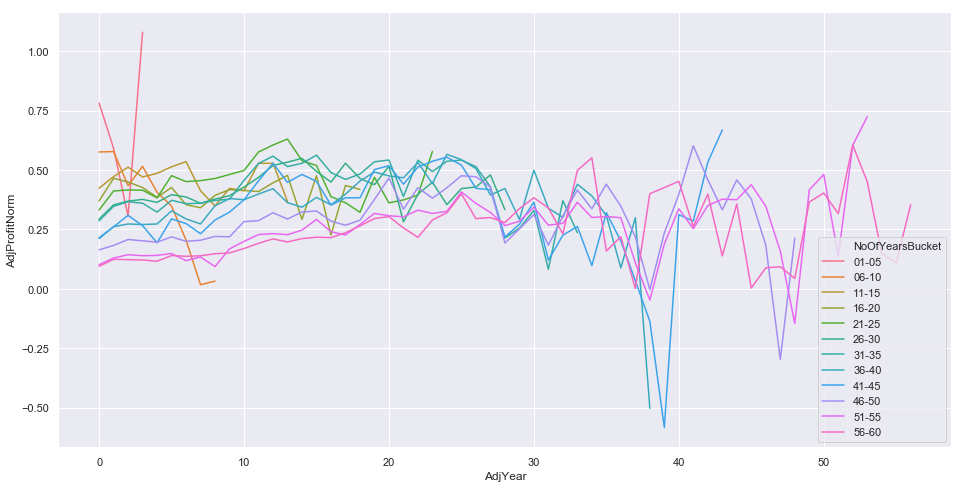

In [307]:
df7 = df6[df6.InTheList == False]
plt.figure(figsize=(16,8))
sns.lineplot(x="AdjYear", y="AdjProfitNorm" , hue = "NoOfYearsBucket", data=df7)

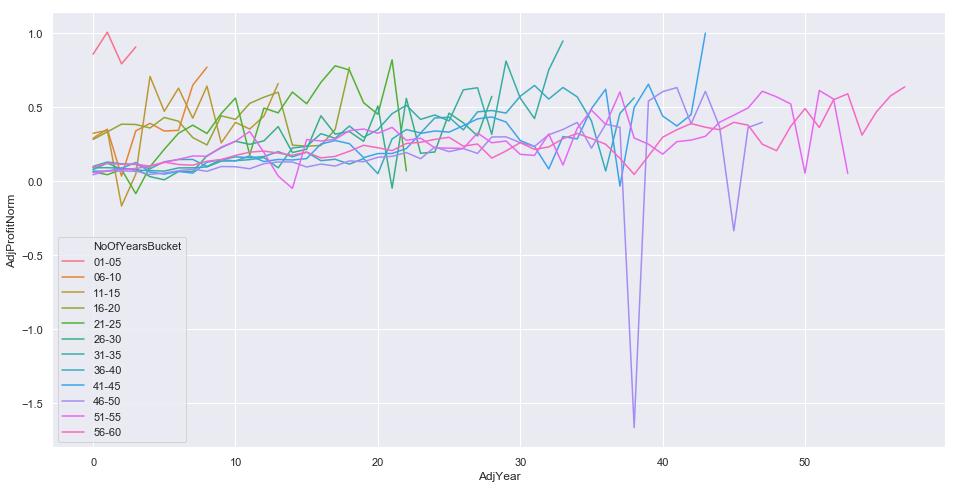

In [275]:
df7 = df6[df6.InTheList == True]
plt.figure(figsize=(16,8))
sns.lineplot(x="AdjYear", y="AdjProfitNorm" , hue = "NoOfYearsBucket", data=df7)

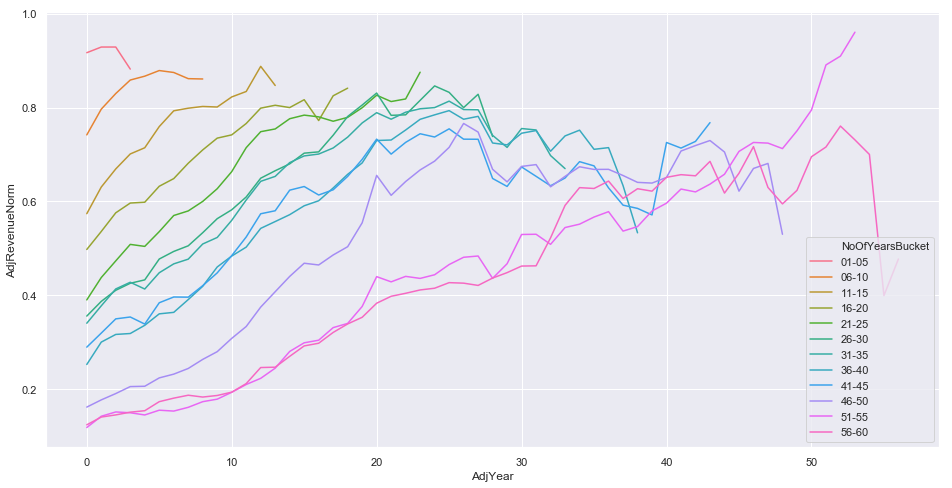

In [276]:
df7 = df6[df6.InTheList == False]
plt.figure(figsize=(16,8))
sns.lineplot(x="AdjYear", y="AdjRevenueNorm" , hue = "NoOfYearsBucket", data=df7)

<Figure size 1152x576 with 0 Axes>

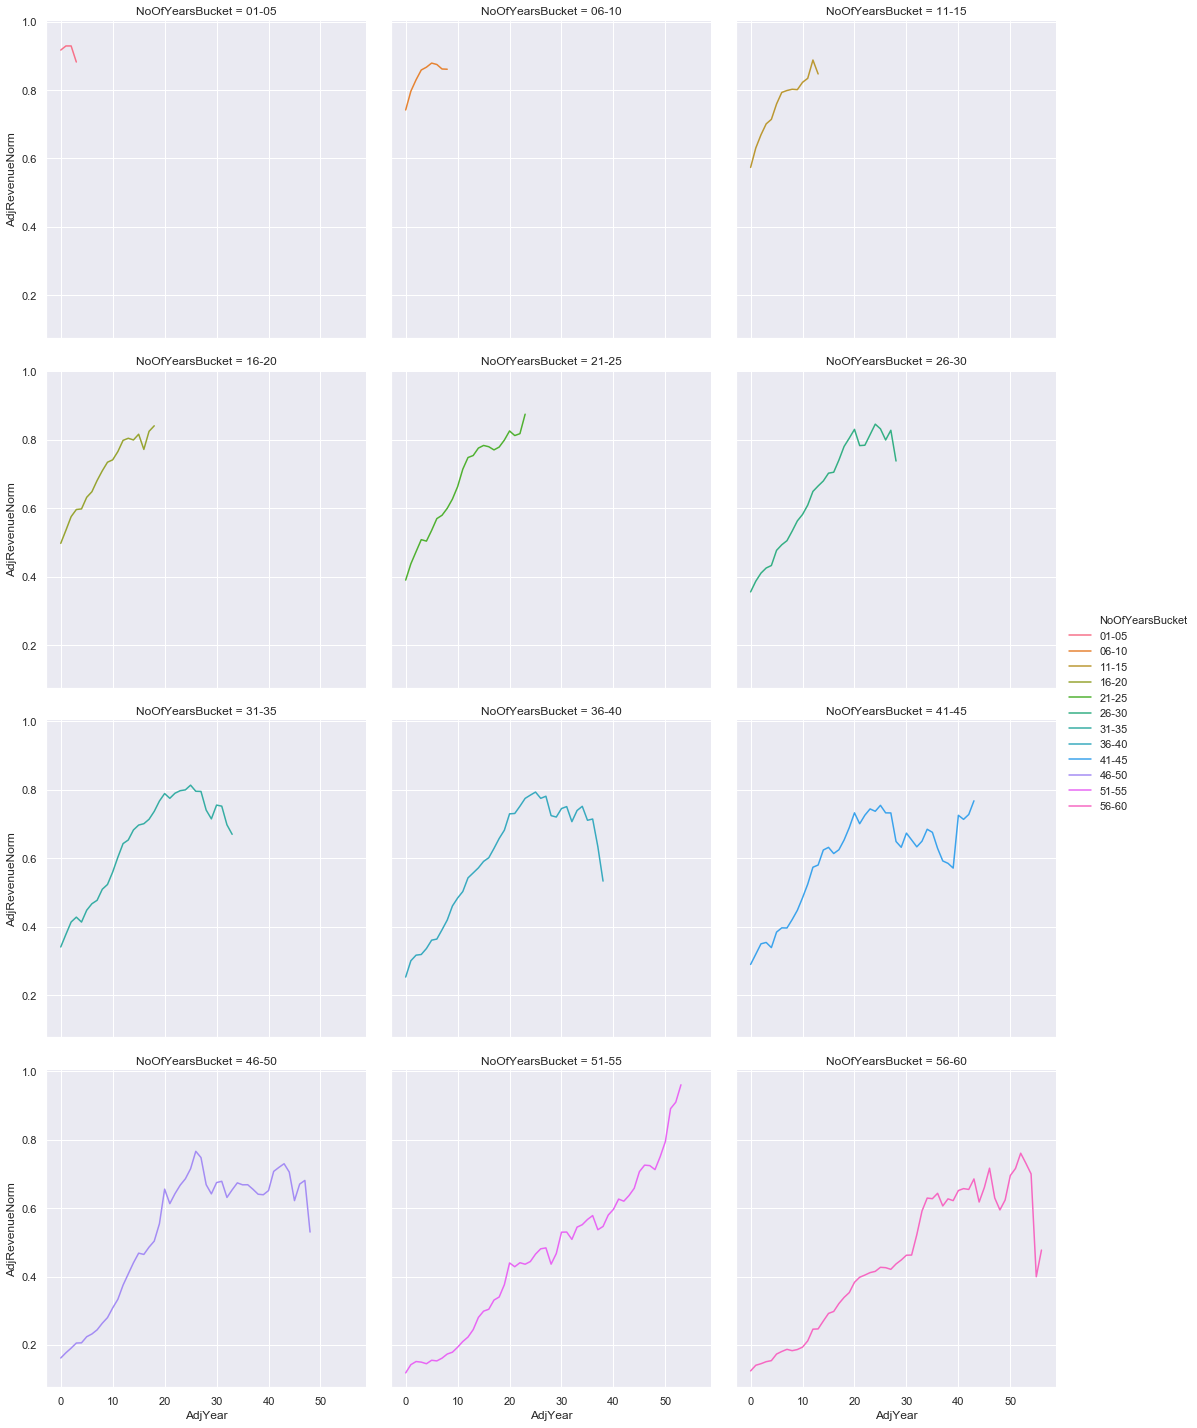

In [332]:
df7 = df6[df6.InTheList == False]
plt.figure(figsize=(16,8))
sns.relplot(x="AdjYear", y="AdjRevenueNorm" , col = "NoOfYearsBucket", hue = "NoOfYearsBucket", col_wrap=3, kind="line", data=df7)

<Figure size 1152x576 with 0 Axes>

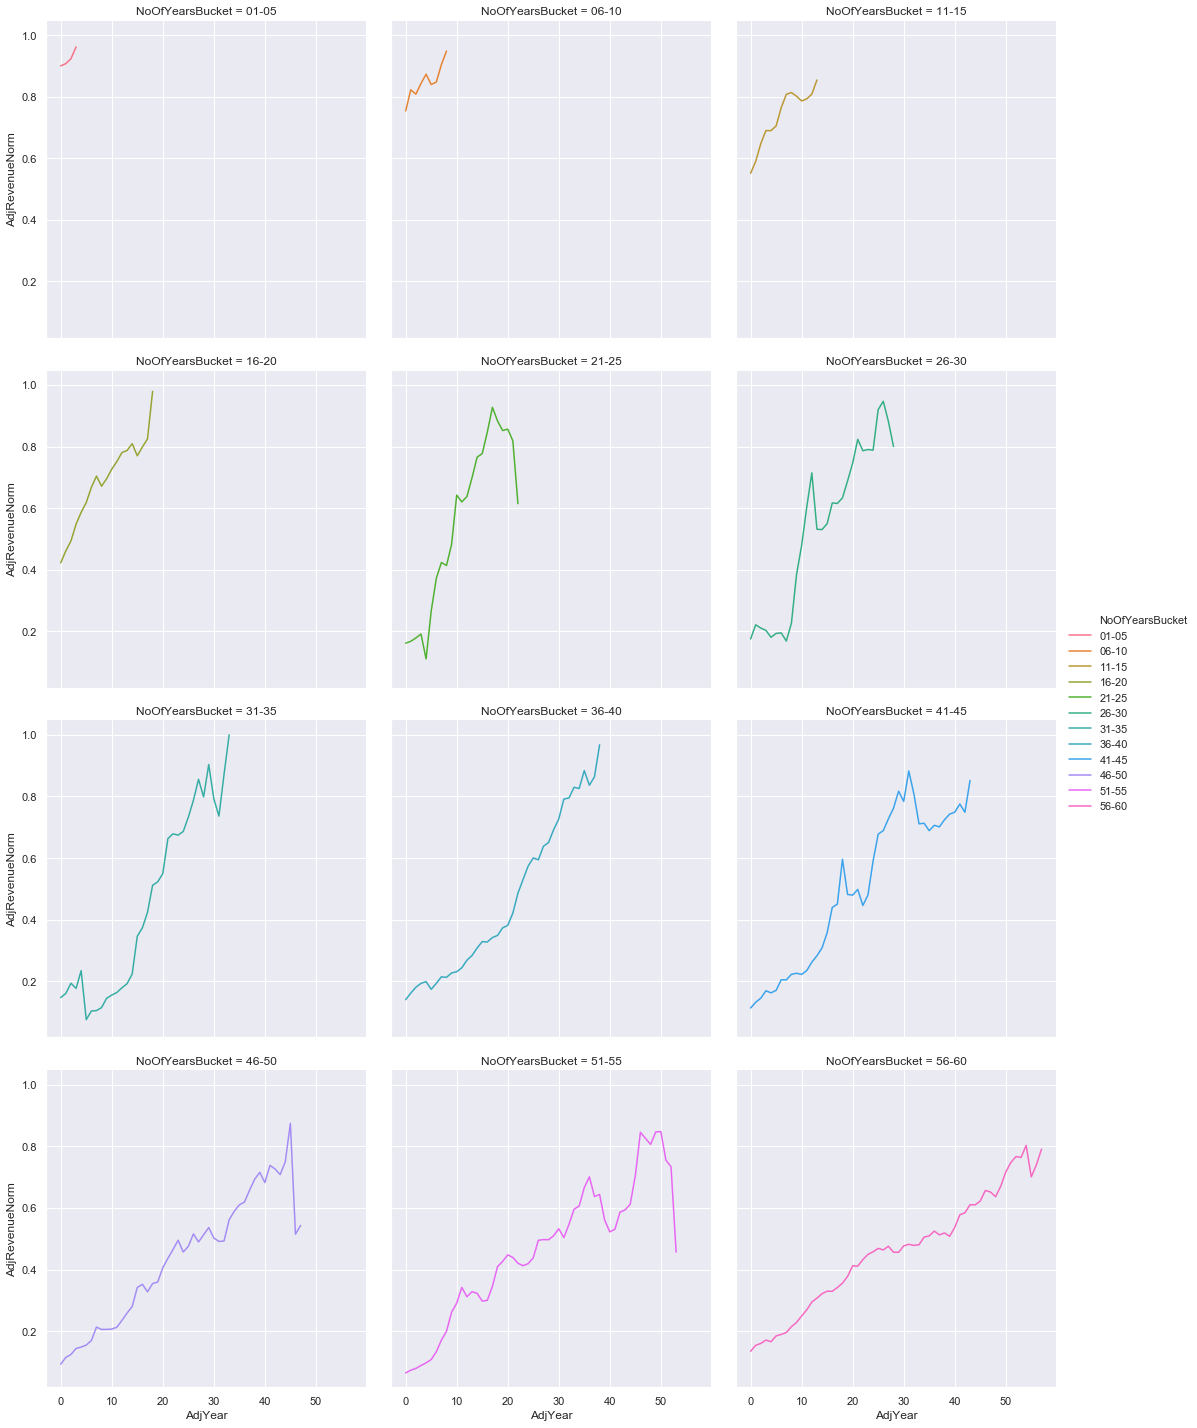

In [331]:
df7 = df6[df6.InTheList == True]
plt.figure(figsize=(16,8))
sns.relplot(x="AdjYear", y="AdjRevenueNorm" , col = "NoOfYearsBucket", hue = "NoOfYearsBucket", col_wrap=3, kind="line", data=df7)

In [314]:
df8 = df5.groupby(["Year", "InTheList"]).mean().reset_index()

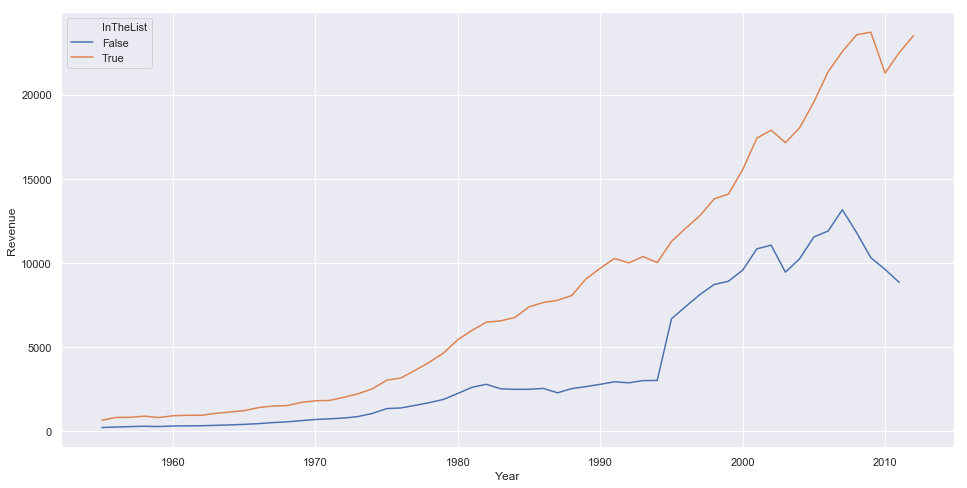

In [315]:
plt.figure(figsize=(16,8))
sns.lineplot(x="Year", y="Revenue" , hue= "InTheList", data=df8)

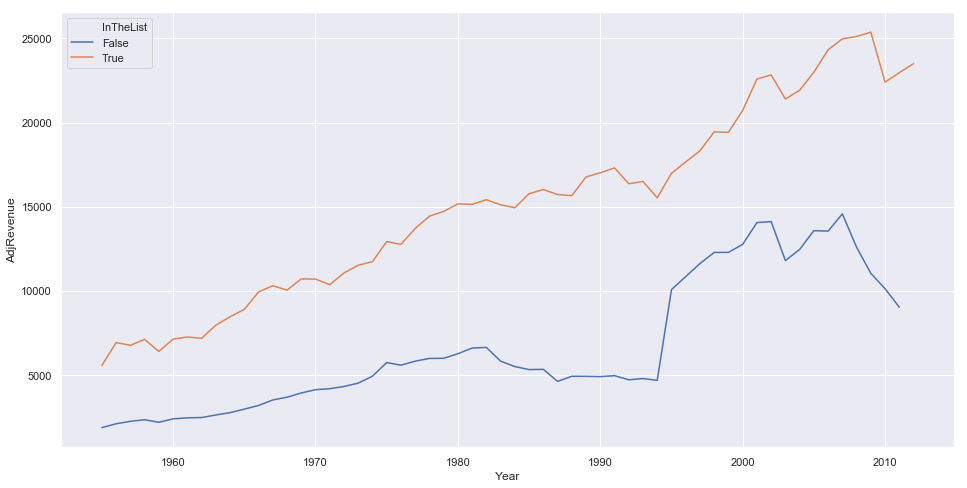

In [317]:
plt.figure(figsize=(16,8))
sns.lineplot(x="Year", y="AdjRevenue" ,hue="InTheList", data=df8)

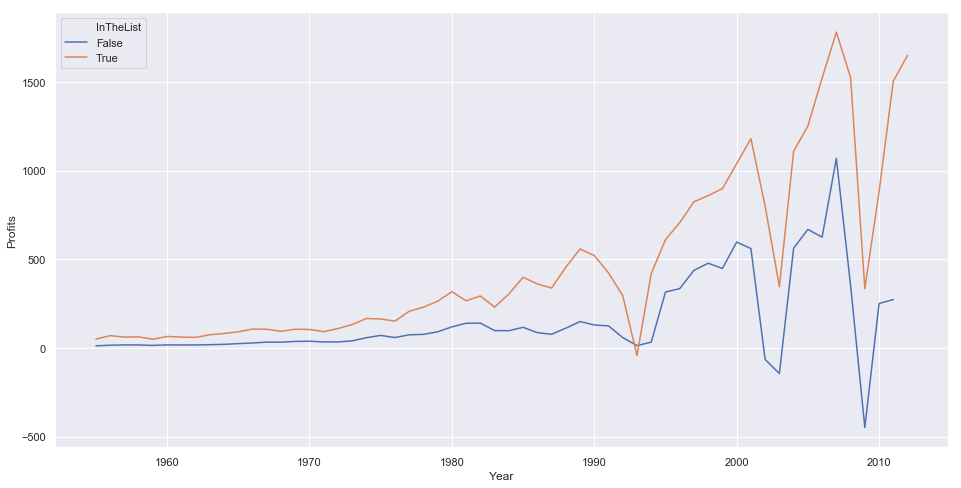

In [318]:
plt.figure(figsize=(16,8))
sns.lineplot(x="Year", y="Profits" ,hue="InTheList", data=df8)

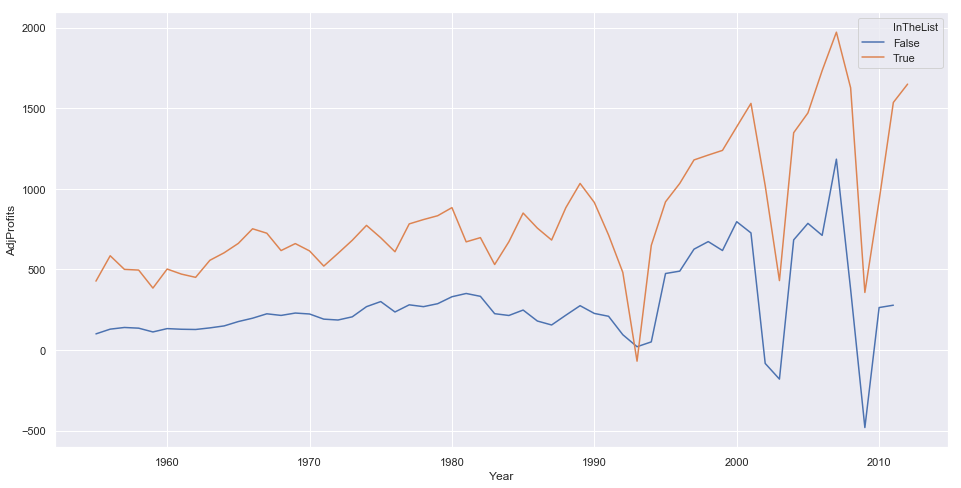

In [319]:
plt.figure(figsize=(16,8))
sns.lineplot(x="Year", y="AdjProfits" ,hue="InTheList", data=df8)

In [373]:
df10 = df5[ (df5["NoOfYearsInList"] > 50) & (df10.Year==2012)]


In [374]:
# df10.LastYearInList[df10.Year==2012]
df10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 28500 to 28969
Data columns (total 30 columns):
Company            77 non-null object
Profits            77 non-null float64
Rank               77 non-null float64
Revenue            77 non-null float64
Year               77 non-null int64
CPI                77 non-null float64
Factor             77 non-null float64
AdjRevenue         77 non-null float64
AdjProfits         77 non-null float64
profitPercent      77 non-null float64
AdjRevenueNorm     77 non-null float64
AdjProfitNorm      77 non-null float64
AdjYear            77 non-null int64
MinRankYear        77 non-null int64
MaxRankYear        77 non-null int64
MinRank            77 non-null float64
MaxRank            77 non-null float64
FirstYearInList    77 non-null int64
LastYearInList     77 non-null int64
MinRevenue         77 non-null float64
MaxRevenue         77 non-null float64
MinYearRevenue     77 non-null float64
MaxYearRevenue     77 non-null float64
MinPro

In [368]:
df10.sample(10)

,Company,Profits,Rank,Revenue,Year,CPI,Factor,AdjRevenue,AdjProfits,profitPercent,...,MaxRevenue,MinYearRevenue,MaxYearRevenue,MinProfit,MaxProfit,MinYearProfit,MaxYearProfit,InTheList,NoOfYearsInList,NoOfYearsBucket
14582,Archer Daniels Midland,110.2,83.0,4292.0,1984,103.883333,2.210113,9485.805458,243.554464,0.025676,...,80676.0,74715.917935,1757.473107,2.8,2162.0,1928.470324,27.538752,True,58,56-60
23369,Murphy Oil,296.8,370.0,4640.7,2001,177.066667,1.296652,6017.374750,384.846430,0.063956,...,31446.3,29443.418302,4961.974366,-194.8,1740.0,1862.118959,139.160435,True,51,51-55
20578,Bristol-Myers Squibb,1812.0,79.0,13767.0,1996,156.850000,1.463780,20151.861337,2652.369633,0.131619,...,21886.0,18486.414566,535.076019,3.6,10612.0,3364.141295,30.869770,True,58,56-60
8501,Exxon Mobil,1461.6,2.0,18700.6,1972,41.816667,5.490488,102675.424424,8024.897615,0.078158,...,452926.0,179442.897623,138792.847826,562.5,45220.0,13405.326819,8779.908445,True,58,56-60
17185,Hormel Foods,60.0,186.0,2293.0,1989,123.966667,1.852062,4246.777501,111.123703,0.026167,...,7895.1,2845.163830,4476.948045,-26.8,474.2,15.434885,217.860894,True,58,56-60
9182,Emerson Electric,63.6,183.0,764.7,1973,44.400000,5.171034,3954.289822,328.877773,0.083170,...,25281.0,12660.851786,519.520049,2.4,2480.0,1096.815331,19.094152,True,55,56-60
6018,CBS,119.7,19.0,2581.4,1967,33.358333,6.882656,17766.886929,823.853864,0.046370,...,14536.4,13985.720937,5592.669754,-11673.4,1660.5,725.439602,424.282929,True,58,56-60
26072,Northrop Grumman,1542.0,73.0,30304.0,2007,207.342417,1.107318,33556.153934,1707.483810,0.050884,...,35291.0,34868.778400,2966.622297,-1262.0,2118.0,1052.651541,57.398479,True,58,56-60
28326,Eastman Kodak,-687.0,327.0,7187.0,2011,224.939167,1.020693,7335.723269,-701.216347,-0.095589,...,20577.0,31548.019170,6022.000000,-1515.0,1407.0,2587.330209,-764.000000,True,58,56-60
15637,Kellogg,281.1,138.0,2930.1,1986,109.608333,2.094676,6137.609384,588.813350,0.095935,...,13198.0,9751.293931,9017.828382,12.7,1247.0,1054.373952,762.042610,True,58,56-60


In [370]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29000 entries, 0 to 28999
Data columns (total 30 columns):
Company            29000 non-null object
Profits            28626 non-null float64
Rank               29000 non-null float64
Revenue            29000 non-null float64
Year               29000 non-null int64
CPI                29000 non-null float64
Factor             29000 non-null float64
AdjRevenue         29000 non-null float64
AdjProfits         28626 non-null float64
profitPercent      28626 non-null float64
AdjRevenueNorm     29000 non-null float64
AdjProfitNorm      28626 non-null float64
AdjYear            29000 non-null int64
MinRankYear        29000 non-null int64
MaxRankYear        29000 non-null int64
MinRank            29000 non-null float64
MaxRank            29000 non-null float64
FirstYearInList    29000 non-null int64
LastYearInList     29000 non-null int64
MinRevenue         29000 non-null float64
MaxRevenue         29000 non-null float64
MinYearRevenue     290

<Figure size 1152x576 with 0 Axes>

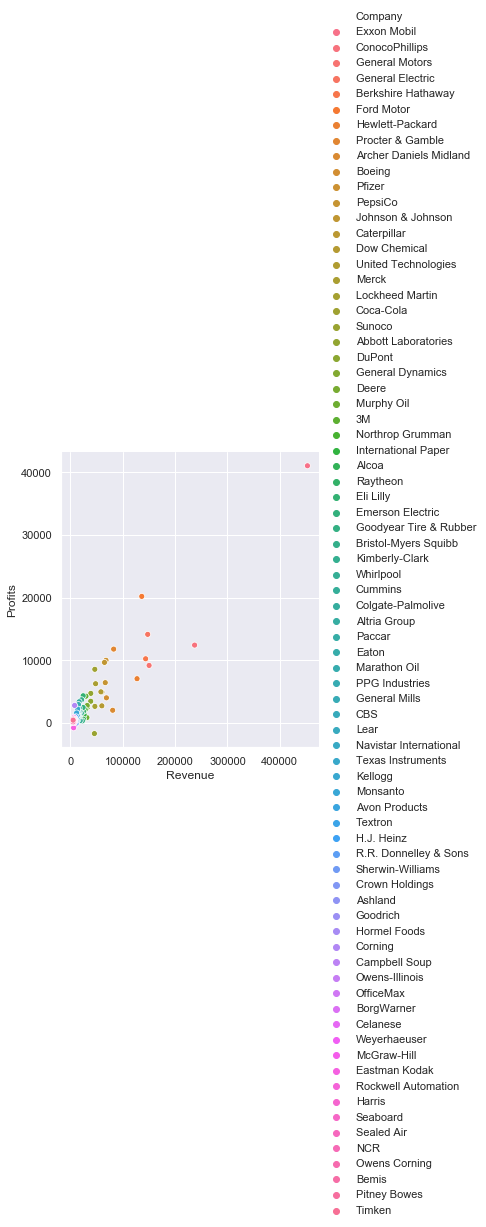

In [375]:
plt.figure(figsize=(16,8))
sns.relplot(x="Revenue", y="Profits" , hue = "Company",   data=df10)

In [377]:
df10.Company

28500               Exxon Mobil
28503            ConocoPhillips
28504            General Motors
28505          General Electric
28506        Berkshire Hathaway
28508                Ford Motor
28509           Hewlett-Packard
28526          Procter & Gamble
28527    Archer Daniels Midland
28538                    Boeing
28539                    Pfizer
28540                   PepsiCo
28541         Johnson & Johnson
28545               Caterpillar
28546              Dow Chemical
28547       United Technologies
28556                     Merck
28557           Lockheed Martin
28558                 Coca-Cola
28560                    Sunoco
28570       Abbott Laboratories
28571                    DuPont
28591          General Dynamics
28596                     Deere
28597                Murphy Oil
28601                        3M
28603          Northrop Grumman
28610       International Paper
28614                     Alcoa
28616                  Raytheon
                  ...          
28699   

In [381]:
df5[df5.Company == "Wal-mart Stores"]

,Company,Profits,Rank,Revenue,Year,CPI,Factor,AdjRevenue,AdjProfits,profitPercent,...,MaxRevenue,MinYearRevenue,MaxYearRevenue,MinProfit,MaxProfit,MinYearProfit,MaxYearProfit,InTheList,NoOfYearsInList,NoOfYearsBucket
